In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as sk
from scipy.optimize import curve_fit
from scipy.stats import pearsonr
from RegscorePy import *
from scalingAnalysis import *
from IPython.core.debugger import set_trace
import lmfit
##### This script is to run basic scaling law analyses

# User Configs


In [16]:
# years = "2013-2016"
years = "2000-2005"


#what features to analyze
# feats = ["GDP","Violent Crime","Total Robberies"]#,"Number of Visitors (Estimate by Accommodation GDP)"]
feats = ["GDP","Total Robberies","Connectivity (asymmetric)"]#"Global Firm Presence (without Connectivity)",Unemployment"
#feats = ['Ratio of Global Econ']
# feats = ["Total Employed"]#['GDP/Job']#["Patents"]

# feats to be plotted on a linear regression rather than log-log
linearFeats = []#["Ratio of Global Econ"]

# what countries to analyze. 
countries = [[
"United States"
#'Australia',
#'Canada',
# 'Germany',
# 'Spain',
# 'France',
# 'United Kingdom',
# 'Italy',
# 'United States (Census)'
]]

# set true if running on US census data
USData = False

# minimum number of datapoints to plot
dataPlotMin = 7

# includeTag = 'ALL/SEPARATE' # this plots all countries on individual country plots
#includeTag = 'ALL/COMBINED' # this plots all countries together
#includeTag = 'ALL/COMBINED+SEPARATE' # this plots each country individually plus all of EU as one (TODO: Not yet implemented)
includeTag = 'LIST' # this allows manual lists of countries in "countries" above

In [9]:
# aesthetic parameteres
plt.rc('xtick', labelsize=18)     
plt.rc('ytick', labelsize=18)
# font = {'family' : 'normal',
#         #'weight' : 'bold',
#         'size'   : 16}
# plt.rc('font', **font)
plt.rcParams.update({'font.size': 16})

# process run parameters and read in Data

In [17]:
if includeTag == 'ALL/SEPARATE':
    countries = []
    #for country in allCountries:
    countries = list(map(lambda x: [x], allCountries))
elif includeTag == 'ALL/COMBINED':
    countries = [allCountries]
elif includeTag == 'LIST':
    countries = countries
else:
    print("WHAT COUNTRIES DO YOU WANT?")

# map, mapping countryname to dataframe
data = {}

# TODO: Include error bars



if USData:
    allCountries = ['United States (Census)']
    countries = [['United States (Census)']]
    # input data file
    fIn = "FeaturesUS"+years.replace("-","_")+".xls"
else:
    fIn = "Features"+years.replace("-","_")+".xls"
for country in allCountries:
    data[country] = pd.read_excel(fIn,sheet_name=country)

In [7]:
# data['United States (Census)']['V+R+B Crime'] = data['United States (Census)']['Violent Crime'] + \
#     data['United States (Census)']['Total Robberies'] + \
#     data['United States (Census)']['Burglary']
# # data['United States (Census)']
# # feats.append('V+R+B Crime')
# # data['United States (Census)']['V+R Crime'] = data['United States (Census)']['Violent Crime'] + \
# #     data['United States (Census)']['Total Robberies'] 
# # data['United States (Census)']
# feats.append('V+R Crime')
# # feats.append('Burglary')

# Run Analysis

<Figure size 432x288 with 0 Axes>

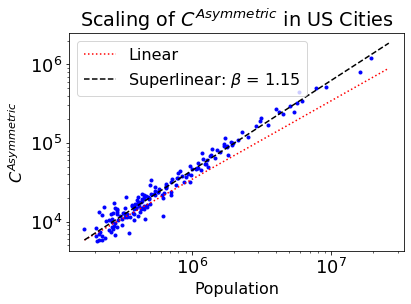

NameError: name 'feat' is not defined

In [18]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes,mark_inset

for feat in feats:
    for countryList in countries:
        plotData = getDataFromList(data,countryList,["Population",feat])

        # skip over countryLists without data
        if plotData.empty:
            msg = 'No Data for country {} and feature {}'.format(country,feat)
            print(msg)
            continue

        # skip over countryLists with less than a set number of datapoints
        if len(list(plotData.index)) < dataPlotMin:
            msg = 'Not Enough Data for country {} and feature {}'.format(country,feat)
            print(msg)
            continue

        #extract Population as x-axis and the feature you're analyzing as the y-axes, such as GDP
        x_pop = plotData["Population"]
        y_feat = plotData[feat]

        # get scaling parameters
        Beta,y0 = getScaleParams(plotData,feat,linearFeats) 


        # plot standard scaling distributions

        countryListName = ""
        if includeTag == 'ALL/COMBINED':
            countryListName = "AllCountries"
        else:
            for country in countryList:
                app = country + "-"
                countryListName = countryListName + (app)
        outDir = "Figures/ScalingFeatures/"+years
        if feat=="GDP/Job":
            featLbl = "GDP per Job"
        else:
            featLbl = feat
        outName = outDir + "/" +countryListName[:-1]+"_"+featLbl+".png"

        plt.figure(outName)

        if Beta>1:
            lbl = "Superlinear: $\\beta$ = {}".format(str(round(Beta,2)))
        elif Beta<1:
            lbl = "Sublinear: $\\beta$ = {}".format(str(round(Beta,2)))
        else:
            lbl = "Linear, Beta = 1"

        #linFit = np.polyfit(plotData["Population"],plotData[feat],1)
        
        ################ FOR PAPER: ##################
        # separate two points to demonstrate 

        # sort list
        
        # choose 2nd largest (LA)
        x_pop, y_feat = (list(t) for t in zip(*sorted(zip(x_pop,y_feat))))

        x_real,y_real = x_pop[-2],y_feat[-2]
        x_pred,y_pred = x_real, y0*x_real**Beta#Beta*x_real+y0
        
        
        fig, ax = plt.subplots() # create a new figure with a default 111 subplot

                

        # plot scaling fitting 
        ax.loglog(x_pop, y_feat, 'bo',markersize=3)
#         ax.plot([x_real,x_pred], [y_real,y_pred], 'r_-',markersize=8)
#         ax.loglog([x_real,x_pred], [y_real,y_pred], 'r-',markersize=3)
        x_space = np.linspace(np.min(x_pop),np.max(x_pop)*1.35,len(x_pop))
        #plot null hypothesis linear fit
        ax.loglog(x_space, y0*np.min(x_pop)**Beta/np.min(x_pop)*x_space, ':r',label="Linear") 
        
        ax.loglog(x_space, y0*x_space**Beta, '--k',label=lbl)
        bottom,top = plt.ylim()
#         plt.ylim((bottom,top*15))
        
        
        # create name for plot
        countryListName = ""
        for country in countryList:
            app = country + ", "
            countryListName = countryListName + (app)
        if "Conn" in featLbl:
            featLbl = "Connectivity (Asymm)"
        plotName = featLbl + " scaling for " + countryListName
        
        
#         # FOR PAPER
#         plotName = "Scaling of {} in US Cities".format(featLbl)
        plotName = "Scaling of $C^{Asymmetric}$ in US Cities"
        
        # create labels, legends, etc
        plt.title(plotName)
        # TODO: remove after getting paper figure
        plt.legend()
        plt.xlabel('Population')
        yLab = feat
#         plt.ylabel(yLab)
        plt.ylabel("$C^{Asymmetric}$")
        
        #############################################
        
        
#         # plot scaling fitting 
#         if feat in linearFeats:
#             plt.loglog(x_pop, y_feat, 'bo')
#             x_space = np.linspace(np.min(x_pop),np.max(x_pop),len(x_pop))
#             plt.loglog(x_space, Beta*x_space+y0, '--k',label=lbl)

#         else:
#             plt.loglog(x_pop, y_feat, 'bo',markersize=3)
#             x_space = np.linspace(np.min(x_pop),np.max(x_pop),len(x_pop))
#             plt.loglog(x_space, y0*x_space**Beta, '--k',label=lbl)

#             # plot null hypothesis linear fit  FIXME
#         plt.loglog(x_space, y0*np.min(x_pop)**Beta/np.min(x_pop)*x_space, ':r',label="Linear Fit") 

        



        plt.show()
        #save to file

        #plt.savefig(outName)
        plt.close()

<Figure size 432x288 with 0 Axes>

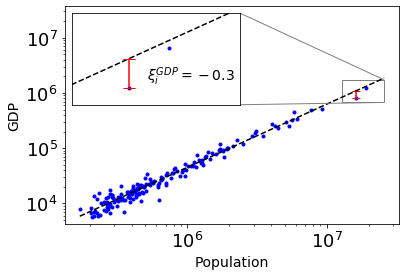

No Data for country United States and feature Disposable Income per Household
No Data for country United States and feature Air Traffic


<Figure size 432x288 with 0 Axes>

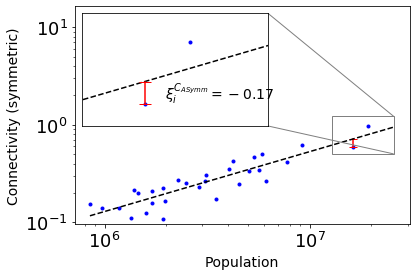

In [104]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes,mark_inset

for feat in feats:
    for countryList in countries:
        plotData = getDataFromList(data,countryList,["Population",feat])

        # skip over countryLists without data
        if plotData.empty:
            msg = 'No Data for country {} and feature {}'.format(country,feat)
            print(msg)
            continue

        # skip over countryLists with less than a set number of datapoints
        if len(list(plotData.index)) < dataPlotMin:
            msg = 'Not Enough Data for country {} and feature {}'.format(country,feat)
            print(msg)
            continue

        #extract Population as x-axis and the feature you're analyzing as the y-axes, such as GDP
        x_pop = plotData["Population"]
        y_feat = plotData[feat]

        # get scaling parameters
        Beta,y0 = getScaleParams(plotData,feat,linearFeats) 


        # plot standard scaling distributions

        countryListName = ""
        if includeTag == 'ALL/COMBINED':
            countryListName = "AllCountries"
        else:
            for country in countryList:
                app = country + "-"
                countryListName = countryListName + (app)
        outDir = "Figures/ScalingFeatures/"+years
        if feat=="GDP/Job":
            featLbl = "GDP per Job"
        else:
            featLbl = feat
        outName = outDir + "/" +countryListName[:-1]+"_"+featLbl+".png"

        plt.figure(outName)

        if Beta>1:
            lbl = "Superlinear: Beta = "+str(round(Beta,2))
        elif Beta<1:
            lbl = "Sublinear: Beta = "+str(round(Beta,2))
        else:
            lbl = "Linear, Beta = 1"

        #linFit = np.polyfit(plotData["Population"],plotData[feat],1)
        
        ################ FOR PAPER: ##################
        # separate two points to demonstrate 

        # sort list
        
        # choose 2nd largest (LA)
        x_pop, y_feat = (list(t) for t in zip(*sorted(zip(x_pop,y_feat))))

        x_real,y_real = x_pop[-2],y_feat[-2]
        x_pred,y_pred = x_real, y0*x_real**Beta#Beta*x_real+y0
        
        
        fig, ax = plt.subplots() # create a new figure with a default 111 subplot

        
        # plot scaling fitting 
        ax.loglog(x_pop, y_feat, 'bo',markersize=3)
        ax.plot([x_real,x_pred], [y_real,y_pred], 'r_-',markersize=8)
#         ax.loglog([x_real,x_pred], [y_real,y_pred], 'r-',markersize=3)
        x_space = np.linspace(np.min(x_pop),np.max(x_pop)*1.35,len(x_pop))
        ax.loglog(x_space, y0*x_space**Beta, '--k',label=lbl)
        bottom,top = plt.ylim()
        plt.ylim((bottom,top*15))
        
        
        # create name for plot
        countryListName = ""
        for country in countryList:
            app = country + ", "
            countryListName = countryListName + (app)
        if "Conn" in featLbl:
            featLbl = "Connectivity (Asymm)"
        plotName = featLbl + " scaling for " + countryListName
        
#         # FOR PAPER
#         plotName = "Scaling of {} in US Cities".format(featLbl)
        
        # create labels, legends, etc
#         plt.title(plotName["-1"])
        # TODO: remove after getting paper figure
#         plt.legend(loc='lower right')
        plt.xlabel('Population')
        yLab = feat
        plt.ylabel(yLab)
        
        
        if "GDP" in feat:
            zoom_f = 4
        elif "Connect" in feat:
            zoom_f = 3
        
        axins = zoomed_inset_axes(ax, zoom_f, loc=2) # zoom-factor: 2.5, location: upper-left
        axins.set_yticklabels([])
        axins.set_xticklabels([])
        axins.loglog(x_pop, y_feat, 'bo',markersize=3)
        axins.loglog(x_space, y0*x_space**Beta, '--k',label=lbl)
        axins.plot([x_real,x_pred], [y_real,y_pred], 'r_-',markersize=12)
        if "GDP" in feat:
            axins.text(x_pred*1.08, y_pred*0.8, r"$\xi^{{GDP}}_{{i}} = {}$".format(round(np.log(y_real/y_pred),2)), fontsize=14)
        elif "Connect" in feat:
            axins.text(x_pred*1.08, y_pred*0.87, r"$\xi^{{C}}_{{i}} = {}$".format(round(np.log(y_real/y_pred),2)), fontsize=14)
        
        
        
        if "GDP" in feat:
            x1, x2, y1, y2 = x_real*0.79,x_pop[-1]*1.34,min(y_pred,y_real)*.84,y_feat[-1]*1.44 # specify the limits
        elif "Connect" in feat:
            x1, x2, y1, y2 = x_real*0.79,x_pop[-1]*1.34,min(y_pred,y_real)*.84,y_feat[-1]*1.25 # specify the limits
            
        axins.set_xlim(x1, x2) # apply the x-limits
        axins.set_ylim(y1, y2) # apply the y-limits
#         axins.set_xticks([],[])
#         axins.set_yticks([],[])
#         axins.tick_params(
#             axis='x',          # changes apply to the x-axis
#             which='both',      # both major and minor ticks are affected
#             bottom=False,      # ticks along the bottom edge are off
#             top=False,         # ticks along the top edge are off
#             labelbottom=False)
        axins.tick_params(axis='both',
                          which='both',
                          bottom=False,
                          top=False,
                          labelbottom=False,
                          right=False,
                          left=False,
                          labelleft=False)
#         axins.xlabel('')
#         axins.ylabel('')


        """TODO: units on Connectivity"""
        
        
        mark_inset(ax, axins, loc1=4, loc2=1, fc="none", ec="0.5")
        
        #############################################
        
#         plot null hypothesis linear fit
#         ax.loglog(x_space, y0*np.min(x_pop)**Beta/np.min(x_pop)*x_space, ':r',label="Linear Fit") 
        
        
#         # plot scaling fitting 
#         if feat in linearFeats:
#             plt.loglog(x_pop, y_feat, 'bo')
#             x_space = np.linspace(np.min(x_pop),np.max(x_pop),len(x_pop))
#             plt.loglog(x_space, Beta*x_space+y0, '--k',label=lbl)

#         else:
#             plt.loglog(x_pop, y_feat, 'bo',markersize=3)
#             x_space = np.linspace(np.min(x_pop),np.max(x_pop),len(x_pop))
#             plt.loglog(x_space, y0*x_space**Beta, '--k',label=lbl)

#             # plot null hypothesis linear fit  FIXME
#         plt.loglog(x_space, y0*np.min(x_pop)**Beta/np.min(x_pop)*x_space, ':r',label="Linear Fit") 

        



        plt.show()
        #save to file

        #plt.savefig(outName)
        plt.close()

Name         Value      Min      Max   Stderr     Vary     Expr Brute_Step
Beta_int    0.9875      0.5        3     None     True     None     None
Beta_net     2.928      0.5        3     None     True     None     None
n         1.054e-05     -inf      inf     None     True     None     None
y1         0.01168        0      inf     None     True     None     None
1.5727632136296978


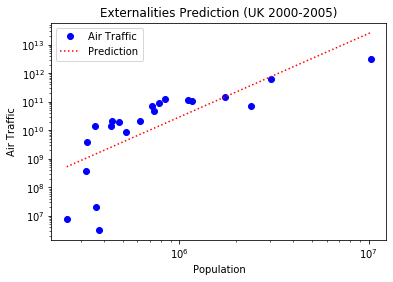

In [19]:
y0 = 0.0074266411


def connFunc(pop, y1,n,Beta_net,Beta_int):
#def connFunc(pop, y1,n):
    prediction = n*(y0*pop**(Beta_net) - y1*pop**(Beta_int))
    #prediction = n*(y0*pop**(1.12) - y1*pop**(1.08))
    with np.nditer(prediction, op_flags=['readwrite']) as it:
        for x in it:
            if x < 0:
                x[...] = 1
    return prediction

def logResidual(params, x, data):
    #model = connFunc(x,params['y1'],params['n'])
    model = connFunc(x,params['y1'],params['n'],params['Beta_net'],params['Beta_int'])
    return np.log(data)-np.log(model)

#connTag = "Global Firm Presence (without Connectivity)"
connTag = "Air Traffic"

UKData = data["United Kingdom"][["Population",connTag]].dropna()
#y0 = 5080677.3/10287135.8


externalities = UKData[connTag]*100000

params = lmfit.Parameters()
#params.add_many(('n',790,True),('y1',y0,True,0))
params.add_many(('n',790,True),('y1',y0,True,0),('Beta_net',1.12,True,0.5,3),('Beta_int',1.08,True,0.5,3))
#params.add_many(('n',790,True),('y1',y0,True,0),('Beta_net',1.12,True,1,1.3),('Beta_int',1.08,True,0.8,1.3))

fit = lmfit.minimize(logResidual, params, args=(UKData["Population"], externalities))
fitParams = fit.params
fitParams.pretty_print()
print(fitParams['y1']/y0)

#print(connFunc(1000))

plt.figure("test connections")

plt.loglog(UKData["Population"],externalities,'bo',label="Air Traffic")
x_space = np.linspace(np.min(UKData["Population"]),np.max(UKData["Population"]),1001)
#plt.loglog(1,1)
plt.loglog(x_space,connFunc(x_space,fitParams['y1'],fitParams['n'],fitParams['Beta_net'],fitParams['Beta_int']),':r',label="Prediction")
#plt.loglog(x_space,connFunc(x_space,fitParams['y1'],fitParams['n']),':r')

plotName = "Externalities Prediction (UK "+years+")"

plt.title(plotName)
plt.legend()
plt.xlabel('Population')
plt.ylabel(connTag)
#save to file

outDir = "Figures/InclusiveExclusive/"
outName = outDir + "UK_"+years+".png"

plt.savefig(outName)
plt.show()
#plt.close()


Name         Value      Min      Max   Stderr     Vary     Expr Brute_Step
Beta_int      1.09        1      1.3        0    False     None     None
Beta_net      1.11        1      1.3        0    False     None     None
n            78.33     -inf      inf    58.03     True     None     None
y1         0.01051        0      inf 0.004046     True     None     None
0.8462732539907967


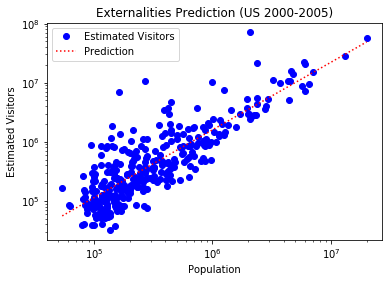

In [22]:
USData = pd.read_excel("FeaturesUS2013_2016.xls")
USData = USData[["Population","Number of Visitors (Estimate by Accommodation GDP)"]].dropna()
pop = USData["Population"]
visitors = USData["Number of Visitors (Estimate by Accommodation GDP)"]
#y0 = 15080677.3/10287135.8
y0 = 0.012414861898723

def connFunc(pop, y1,n,Beta_net,Beta_int):
    #prediction = n*(y0*pop**(1.11) - y1*pop**(1.09))
    prediction = n*(y0*pop**(Beta_net) - y1*pop**(Beta_int))
    with np.nditer(prediction, op_flags=['readwrite']) as it:
        for x in it:
            if x < 0:
                x[...] = 1
    return prediction

def logResidual(params, x, data):
    #model = connFunc(x,params['y1'],params['n'])
    model = connFunc(x,params['y1'],params['n'],params['Beta_net'],params["Beta_int"])
    return np.log(data)-np.log(model)


#y0 = 5080677.3/10287135.8
#TODO: Get actual y0 values. These are estimates

params = lmfit.Parameters()
params.add_many(('n',66,True),('y1',y0,True,0),('Beta_net',1.11,False,1,1.3),('Beta_int',1.09,False,1,1.3))

fit = lmfit.minimize(logResidual, params, args=(pop,visitors))
fitParams = fit.params
fitParams.pretty_print()

print(fitParams['y1']/y0)

plt.figure("test connections")
plotName = "Externalities Prediction (US "+years+")"

plt.loglog(pop,visitors,'bo',label='Estimated Visitors')
x_space = np.linspace(np.min(pop),np.max(pop),1001)
#plt.loglog(x_space,connFunc(x_space, fitParams['y1'],fitParams['n']),':r')
plt.loglog(x_space,connFunc(x_space, fitParams['y1'],fitParams['n'],fitParams['Beta_net'],fitParams['Beta_int']),':r',label="Prediction")
plt.title(plotName)
plt.legend()
plt.xlabel('Population')
plt.ylabel("Estimated Visitors")
#save to file

outDir = "Figures/InclusiveExclusive/"
outName = outDir + "US_"+years+".png"

plt.savefig(outName)

plt.show()
plt.close()

In [13]:
data

{'United States (Census)':                                                   City        State  \
 0    Las Vegas-Henderson-Paradise (NV) / Las Vegas-...           NV   
 1    New York-Newark-Jersey City (NY-NJ-PA) / New Y...     NY-NJ-PA   
 2    Los Angeles-Long Beach-Anaheim (CA) / Los Ange...           CA   
 3    Miami-Fort Lauderdale-West Palm Beach (FL) / M...           FL   
 4    Orlando-Kissimmee-Sanford (FL) / Orlando-Kissi...           FL   
 5    Washington-Arlington-Alexandria (DC-VA-MD-WV) ...  DC-VA-MD-WV   
 6    San Francisco-Oakland-Hayward (CA) / San Franc...           CA   
 7    Dallas-Fort Worth-Arlington (TX) / Dallas-Fort...           TX   
 8    Boston-Cambridge-Newton (MA-NH) / Boston-Cambr...        MA-NH   
 9         San Diego-Carlsbad (CA) / San Diego-Carlsbad           CA   
 10   Phoenix-Mesa-Scottsdale (AZ) / Phoenix-Mesa-Sc...           AZ   
 11   Detroit-Warren-Dearborn (MI) / Detroit-Warren-...           MI   
 12   Atlantic City-Hammonton (NJ) / A

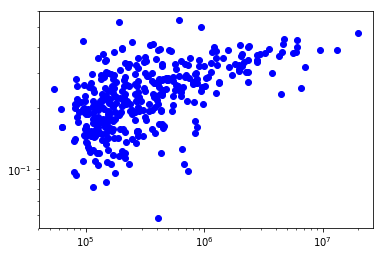

In [17]:
#data = data['United States (Census)']

GDPRatio = data['Ratio of Global Econ']
pop = data['Population']


plt.figure()
plt.loglog(pop,GDPRatio,'bo')
plt.show()

